In [1]:
%load_ext autoreload
%autoreload 2

import csv
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.special import binom
import scipy.stats as st
from scipy.stats import pearsonr, spearmanr, kendalltau
import seaborn as sns

# with open('data.json', 'w') as f:
#     json.dump(data, f)


### *ROCStory dataset construction*

In [2]:
with open('data.json') as f:
    data_dict = json.load(f)

# Create a list of dictionaries
# We take the hypothesis that the first 5 workers are the same because we do not have the data of the workers
rows = []
for key, value in data_dict.items():
    for model, model_data in value['gen'].items():
        for i in range(5):
            row = {
                'Story ID': key,
                'Prompt': value['prompt'],
                'Human': value['gold_response'],
                'Story': model_data['text'],
                'Model': model,
                'Overall Quality': model_data['score'][i],
                'Worker ID': i,
                'average_score': sum(model_data['score'])/len(model_data['score']),
            }
            rows.append(row)


# Convert list of dictionaries to DataFrame
ROC_data = pd.DataFrame(rows)

In [3]:
ROC_data.Model.unique()

array(['fusion', 's2s', 'gpt_kg', 'gpt', 'plan_write'], dtype=object)

### *Dataset Analysis*

Text(0.5, 1.0, 'Worker scores distribution')

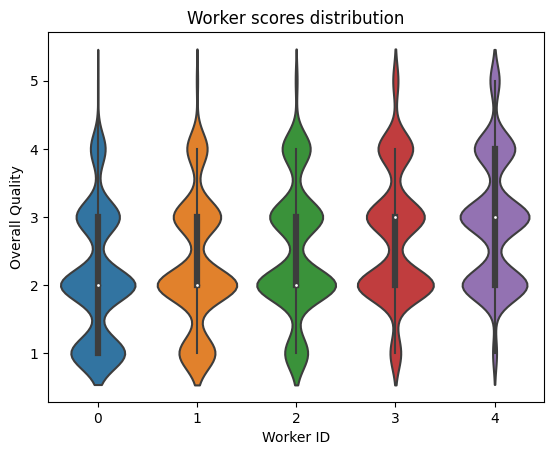

In [4]:
sns.violinplot(data=ROC_data, y="Overall Quality", x="Worker ID",cmap='icefire')
plt.title("Worker scores distribution")

Text(0.5, 1.0, 'Correlation between workers')

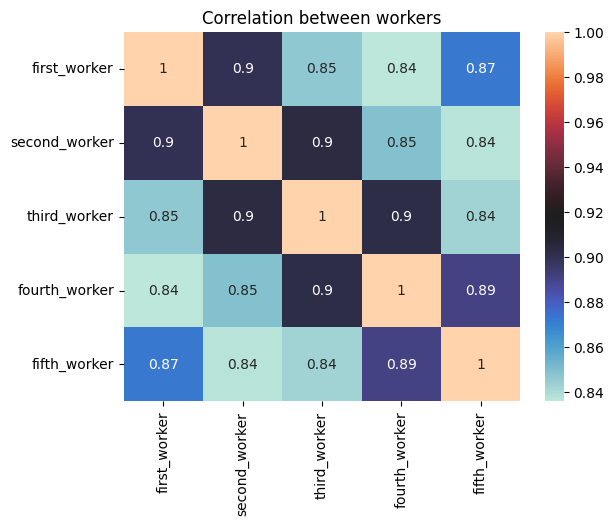

In [5]:
# study the correlation of the scores of the two workers
first_worker=ROC_data[ROC_data["Worker ID"] == 0]['Overall Quality'].reset_index(drop=True)
second_worker=ROC_data[ROC_data["Worker ID"] == 1]['Overall Quality'].reset_index(drop=True)
third_worker=ROC_data[ROC_data["Worker ID"] == 2]['Overall Quality'].reset_index(drop=True)
fourth_worker=ROC_data[ROC_data["Worker ID"] == 3]['Overall Quality'].reset_index(drop=True)
fifth_worker=ROC_data[ROC_data["Worker ID"] == 4]['Overall Quality'].reset_index(drop=True)
df=pd.DataFrame({'first_worker': first_worker, 'second_worker': second_worker, 'third_worker': third_worker, 'fourth_worker': fourth_worker, 'fifth_worker': fifth_worker})
# calculate the correlation matrix between two vectors
corr =df.corr(method='spearman')
# plot the heatmap
sns.heatmap(corr, annot=True, cmap='icefire')
plt.title("Correlation between workers")



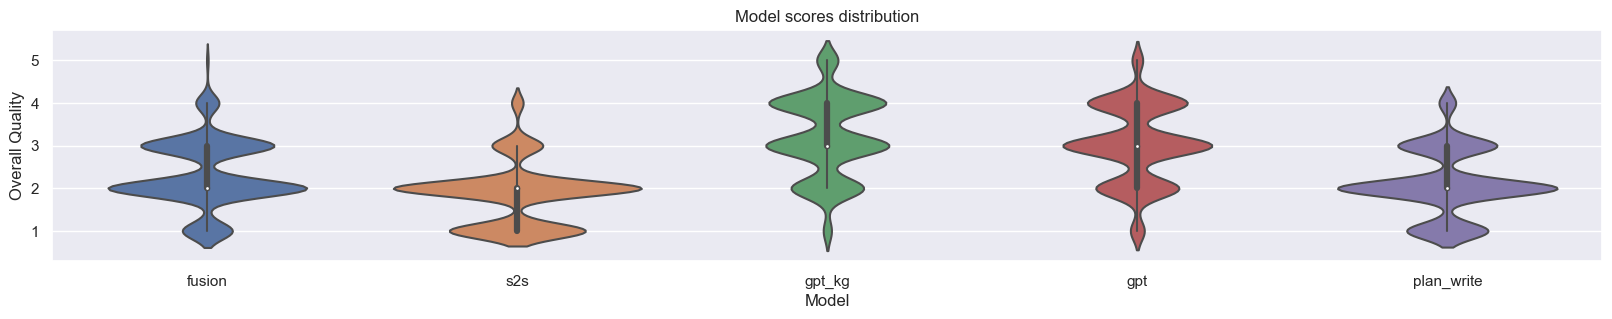

In [6]:

sns.set(rc={"figure.figsize":(20, 3)})
ax = sns.violinplot(x="Model", y='Overall Quality', data=ROC_data)
plt.title("Model scores distribution")
plt.show()

In [7]:
ROC_data.columns

Index(['Story ID', 'Prompt', 'Human', 'Story', 'Model', 'Overall Quality',
       'Worker ID', 'average_score'],
      dtype='object')

### Calculate some AEM on ROCStories dataset

In [8]:
 %reload_ext autoreload

In [31]:
from metrics import ROUGE, BLUE, METEOR, DepthScore, BaryScore, InfoLM,WER, BertScore
Evaluated_df=ROC_data.copy()
# get the first 50 stories
Evaluated_df=Evaluated_df[Evaluated_df['Story ID'].astype(int) < 50]

Evaluated_df=Evaluated_df.groupby(['Story ID', 'Model']).agg({'Human': 'first', 'Story': 'first'}).reset_index()
Evaluated_df=Evaluated_df[['Story ID', 'Human', 'Story', 'Model']]
# set Model and Story ID as index
Evaluated_df.set_index(['Model', 'Story ID'], inplace=True)

In [11]:

# remove [ and ] from the Story and Human
Evaluated_df['Story'] = Evaluated_df['Story'].str.replace('[', '')
Evaluated_df['Story'] = Evaluated_df['Story'].str.replace(']', '')
Evaluated_df['Human'] = Evaluated_df['Human'].str.replace('[', '')
Evaluated_df['Human'] = Evaluated_df['Human'].str.replace(']', '')

# calculate the metrics
Evaluated_df['ROUGE'] = Evaluated_df.apply(lambda x: ROUGE(x['Human'], x['Story']), axis=1)
Evaluated_df['BLEU'] = Evaluated_df.apply(lambda x: BLUE(x['Human'], x['Story']), axis=1)
Evaluated_df['METEOR'] = Evaluated_df.apply(lambda x: METEOR(x['Human'], x['Story']), axis=1)
Evaluated_df['WER'] = Evaluated_df.apply(lambda x: WER(x['Human'], x['Story']), axis=1)
# Evaluated_df['BertScore']=Evaluated_df.apply(lambda x: BertScore([x['Human']], [x['Story']]), axis=1) We had trouble calculating this score
Evaluated_df['DepthScore'] = Evaluated_df.apply(lambda x: DepthScore([x['Human']], [x['Story']]), axis=1)
Evaluated_df['BaryScore'] = Evaluated_df.apply(lambda x: BaryScore([x['Human']], [x['Story']]), axis=1)
#Evaluated_df['InfoLM'] = Evaluated_df.apply(lambda x: InfoLM(x['Human'], x['Story']), axis=1) We had trouble running the infoLM model , it constantly killed the kernel

# we also tried calculating the mover score using the moverscore library but it seems to not be functionning 




Rouge calculated
Bleu calculated
Meteor calculated
WER calculated
DepthScore calculated
BaryScore calculated


C:\Users\33753\AppData\Local\Temp\ipykernel_15896\2307080587.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Evaluated_df['Story'] = Evaluated_df['Story'].str.replace('[', '')
C:\Users\33753\AppData\Local\Temp\ipykernel_15896\2307080587.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Evaluated_df['Story'] = Evaluated_df['Story'].str.replace(']', '')
C:\Users\33753\AppData\Local\Temp\ipykernel_15896\2307080587.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Evaluated_df['Human'] = Evaluated_df['Human'].str.rep

In [28]:
%reload_ext autoreload

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\33753\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [37]:
#  split the BaryScore column into 3 columns
Evaluated_df['BaryScore_W']=Evaluated_df['BaryScore'].apply(lambda x: eval(x)['baryscore_W'][0])
Evaluated_df['baryscore_SD_1']=Evaluated_df['BaryScore'].apply(lambda x: eval(x)['baryscore_SD_1'][0])
Evaluated_df['baryscore_SD_10']=Evaluated_df['BaryScore'].apply(lambda x: eval(x)['baryscore_SD_10'][0])
#  drop the BaryScore column
Evaluated_df.drop(columns=['BaryScore'], inplace=True)
# reset index
Evaluated_df.reset_index(inplace=True)

Evaluated_df.head()


,Story ID,Model,Human,Story,ROUGE,BLEU,METEOR,WER,DepthScore,BaryScore_W,baryscore_SD_1,baryscore_SD_10
0,1,fusion,my kids mean the world to me . i told them thi...,he 'd only live to our cousins . he begged his...,0.153846,9.531678e-301,0.102941,0.971,0.119944,0.955559,1.201278,1.213807
1,1,gpt,my kids mean the world to me . i told them thi...,"i once dated a bumpkin from nyc , who i though...",0.230769,3.776630e-02,0.217889,1.471,0.133390,0.892434,1.186487,1.201720
2,1,gpt_kg,my kids mean the world to me . i told them thi...,in foster care he may have to fight chores for...,0.192308,1.336723e-02,0.153631,1.353,0.124033,0.956541,1.212105,1.223744
3,1,plan_write,my kids mean the world to me . i told them thi...,i have plans to go to a different weekend . i ...,0.153846,1.311042e-02,0.147059,0.912,0.131930,0.821841,1.137319,1.154723
4,1,s2s,my kids mean the world to me . i told them thi...,last year i realized i may keep some cream for...,0.192308,1.713461e-02,0.144509,1.059,0.122828,0.810279,1.139497,1.157313


In [46]:
data=Evaluated_df.merge(ROC_data[['Story ID','Model','average_score']], on=['Story ID', 'Model'], how='left')
data.drop(columns=['Story','Story ID','Human'], inplace=True)
data.rename(columns={'average_score': 'Human'}, inplace=True)
data.head()

,Model,ROUGE,BLEU,METEOR,WER,DepthScore,BaryScore_W,baryscore_SD_1,baryscore_SD_10,Human
0,fusion,0.153846,9.531678e-301,0.102941,0.971,0.119944,0.955559,1.201278,1.213807,1.8
1,fusion,0.153846,9.531678e-301,0.102941,0.971,0.119944,0.955559,1.201278,1.213807,1.8
2,fusion,0.153846,9.531678e-301,0.102941,0.971,0.119944,0.955559,1.201278,1.213807,1.8
3,fusion,0.153846,9.531678e-301,0.102941,0.971,0.119944,0.955559,1.201278,1.213807,1.8
4,fusion,0.153846,9.531678e-301,0.102941,0.971,0.119944,0.955559,1.201278,1.213807,1.8


C:\Users\33753\AppData\Local\Temp\ipykernel_15896\3899561434.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr =data[data['Model'] == model].corr(method='spearman')


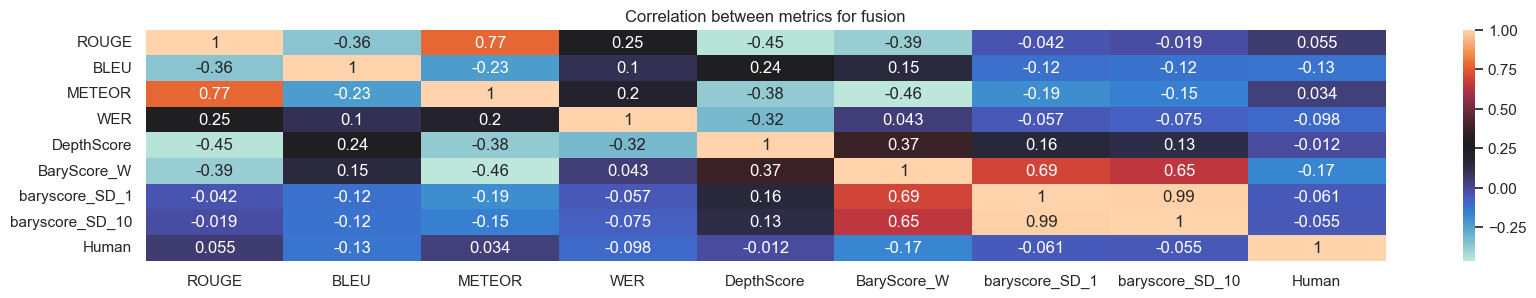

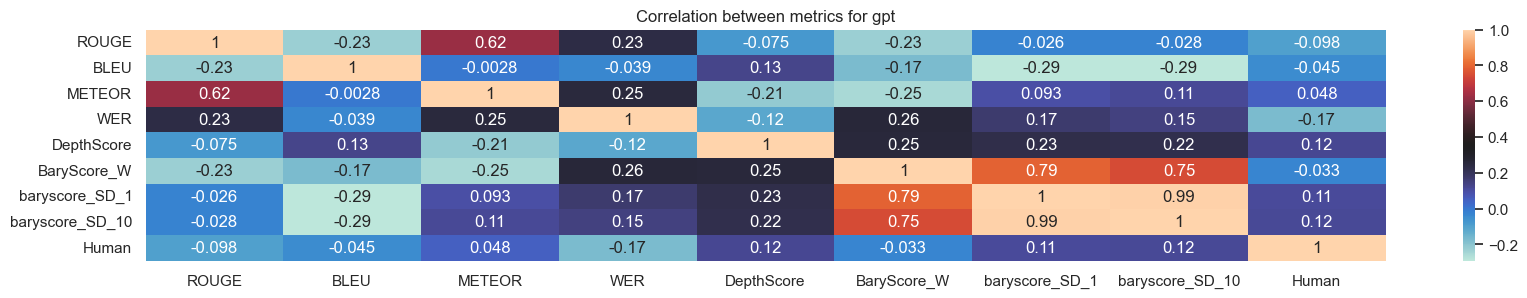

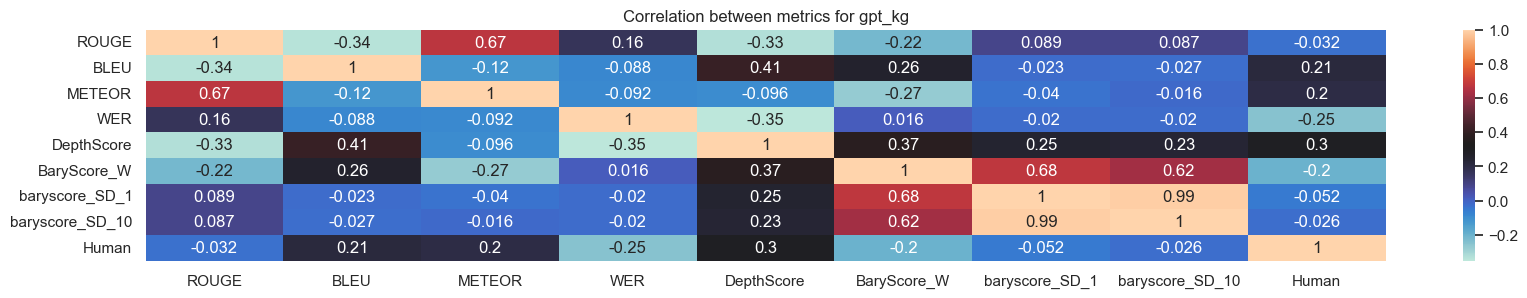

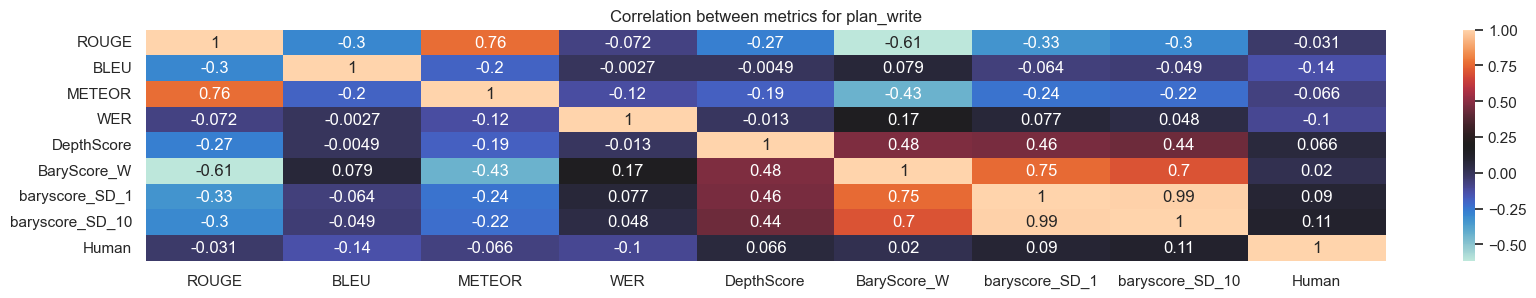

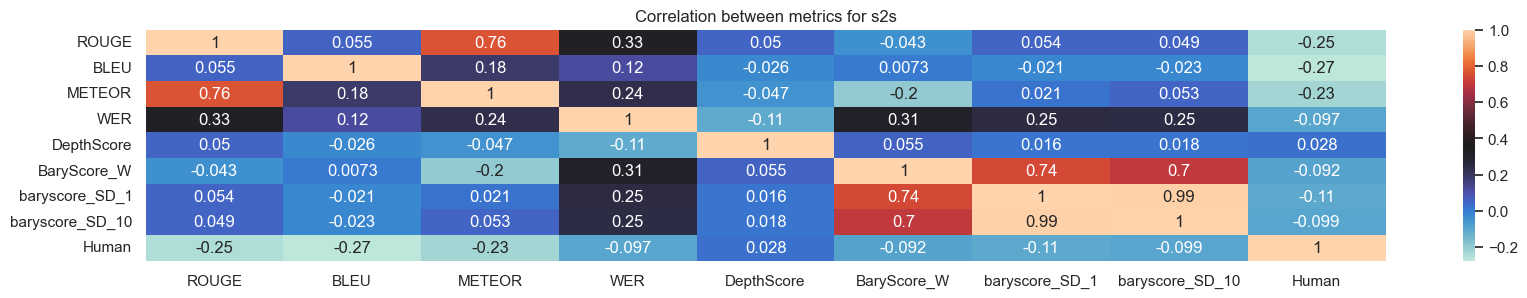

In [48]:
# calculate the correlation matrix for each Model on the same plot
for model in data.Model.unique():
    corr =data[data['Model'] == model].corr(method='spearman')
    # plot the heatmap
    sns.heatmap(corr, annot=True, cmap='icefire')
    plt.title("Correlation between metrics for {}".format(model))
    plt.show()


## Get the metric scores dataset

In [50]:
# create a dataframe with models as indexes and metrics as columns and the values of the cells are a list of all the scores for each story
metrics_scores=data.groupby(['Model']).agg({'ROUGE': lambda x: list(x), 'BLEU': lambda x: list(x), 'METEOR': lambda x: list(x), 'WER': lambda x: list(x), 'DepthScore': lambda x: list(x), 'BaryScore_W': lambda x: list(x), 'baryscore_SD_1': lambda x: list(x), 'baryscore_SD_10': lambda x: list(x), 'Human': lambda x: list(x)}).reset_index()
metrics_scores = metrics_scores.drop(0, axis=0)

metrics_scores.head()

,Model,ROUGE,BLEU,METEOR,WER,DepthScore,BaryScore_W,baryscore_SD_1,baryscore_SD_10,Human
1,gpt,"[0.2307692307692307, 0.2307692307692307, 0.230...","[0.0377663031001884, 0.0377663031001884, 0.037...","[0.217888783549642, 0.217888783549642, 0.21788...","[1.471, 1.471, 1.471, 1.471, 1.471, 0.925, 0.9...","[0.1333901383226958, 0.1333901383226958, 0.133...","[0.8924335508912014, 0.8924335508912014, 0.892...","[1.1864868200363328, 1.1864868200363328, 1.186...","[1.201720000010524, 1.201720000010524, 1.20172...","[2.2, 2.2, 2.2, 2.2, 2.2, 3.6, 3.6, 3.6, 3.6, ..."
2,gpt_kg,"[0.1923076923076923, 0.1923076923076923, 0.192...","[0.013367226419265, 0.013367226419265, 0.01336...","[0.1536312849162011, 0.1536312849162011, 0.153...","[1.353, 1.353, 1.353, 1.353, 1.353, 0.925, 0.9...","[0.1240327178804848, 0.1240327178804848, 0.124...","[0.9565409194329638, 0.9565409194329638, 0.956...","[1.2121049299993816, 1.2121049299993816, 1.212...","[1.2237442853408904, 1.2237442853408904, 1.223...","[2.6, 2.6, 2.6, 2.6, 2.6, 3.8, 3.8, 3.8, 3.8, ..."
3,plan_write,"[0.1538461538461538, 0.1538461538461538, 0.153...","[0.0131104244620987, 0.0131104244620987, 0.013...","[0.1470588235294117, 0.1470588235294117, 0.147...","[0.912, 0.912, 0.912, 0.912, 0.912, 0.875, 0.8...","[0.1319295114123429, 0.1319295114123429, 0.131...","[0.8218409401441414, 0.8218409401441414, 0.821...","[1.1373186109955054, 1.1373186109955054, 1.137...","[1.1547226606556003, 1.1547226606556003, 1.154...","[1.6, 1.6, 1.6, 1.6, 1.6, 2.0, 2.0, 2.0, 2.0, ..."
4,s2s,"[0.1923076923076923, 0.1923076923076923, 0.192...","[0.0171346101296873, 0.0171346101296873, 0.017...","[0.1445086705202312, 0.1445086705202312, 0.144...","[1.059, 1.059, 1.059, 1.059, 1.059, 1.2, 1.2, ...","[0.1228282404163758, 0.1228282404163758, 0.122...","[0.8102790656820866, 0.8102790656820866, 0.810...","[1.1394971294544034, 1.1394971294544034, 1.139...","[1.1573126953955701, 1.1573126953955701, 1.157...","[1.4, 1.4, 1.4, 1.4, 1.4, 1.2, 1.2, 1.2, 1.2, ..."
